## Text classification on the CoLA (the Corpus of Linguistic Acceptability) dataset
<br>

#### Dataset
[CoLA (the Corpus of Linguistic Acceptability)](https://nyu-mll.github.io/CoLA/)
The Corpus of Linguistic Acceptability (CoLA) in its full form consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. The public version provided here contains 9594 sentences belonging to training and development sets, and excludes 1063 sentences belonging to a held out test set. Contact alexwarstadt [at] gmail [dot] com with any questions or issues. Read the [paper](https://arxiv.org/abs/1805.12471) or check out the [source code](https://github.com/nyu-mll/CoLA-baselines) for baselines.

<br>

#### Model
[AlbertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/albert.html?highlight=albertforsequenceclassification) with the [albert-base-v2](https://huggingface.co/albert-base-v2) pretrained model from the [HuggingFace](https://huggingface.co/) library is used to fine-tune text classification on the CoLA dataset.

<br>

#### Objective
Create a model trained on the CoLA dataset to predict whether a sentence is grammatically correct and minimize the misclassification of incorrect grammar cases.

<br>

#### Strategy for dealing with class imbalance
- Resample a balanced dataset by upsampling minority class and downsampling majority class
- Weight the classes for cross entropy loss
- Employ a focal loss to downweight easily classified samples and upweight difficult sample

<br>

#### Evaluation metrics for comparing class imbalance strategies
- Confusion matrix
- Precision
- Recall
- AUC

In [98]:
import time
import datetime
import os
import random
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler

import transformers
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import shap

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

Get the CoLA dataset

In [96]:
!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
!unzip cola_public_1.1.zip

--2021-03-04 16:14:30--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.03s   

2021-03-04 16:14:30 (8.56 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_p

In [103]:
path_train = './cola_public/raw/in_domain_train.tsv'
path_dev = './cola_public/raw/in_domain_dev.tsv'
path_test = './cola_public/raw/out_of_domain_dev.tsv'

df_train = pd.read_csv(path_train, delimiter='\t', header=None,
                       names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_dev = pd.read_csv(path_dev, delimiter='\t', header=None,
                       names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test = pd.read_csv(path_test, delimiter='\t', header=None,
                       names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of dev sentences: {:,}\n'.format(df_dev.shape[0]))
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
df_train.sample(10)

Number of training sentences: 8,551

Number of dev sentences: 527

Number of test sentences: 516



,sentence_source,label,label_notes,sentence
3397,l-93,1,NaN,Jackie chased after the thief.
7277,sks13,0,*,For he to win the race would surprise them.
1191,r-67,1,NaN,The man who I read a statement about is sick.
6490,d_98,1,NaN,"At the end of his speech, the president thanke..."
2476,l-93,1,NaN,Sarah sang the anthem.
5225,kl93,1,NaN,I'm surprised he bought a car.
3504,ks08,1,NaN,Chris must liking syntax.
1425,r-67,1,NaN,Which hat do you believe that she never wore?
2200,l-93,0,*,Celia braided.
2771,l-93,1,NaN,Steve tossed the ball.


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
sentence_source    8551 non-null object
label              8551 non-null int64
label_notes        2527 non-null object
sentence           8551 non-null object
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


Check for class imbalance

Text(0.5,1,'CoLA train dataset')

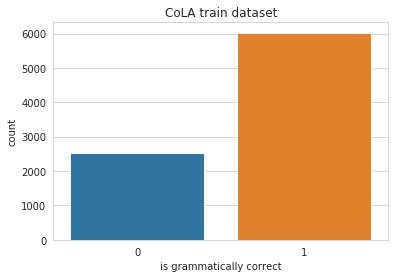

In [100]:
sns.set_style('whitegrid')
sns.countplot(df_train.label)
plt.xlabel('is grammatically correct')
plt.title('CoLA train dataset')

Sample sentence and tokenization using AlbertTokenizer

In [102]:
pretrained_model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)
tokens = tokenizer.tokenize(df_train.sentence.values[0])
token_ids = tokenizer.encode(df_train.sentence.values[0], add_special_tokens=True)

print(f'Sentence: {df_train.sentence.values[0]}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: Our friends won't buy this analysis, let alone the next one we propose.
Tokens: ['▁our', '▁friends', '▁won', "'", 't', '▁buy', '▁this', '▁analysis', ',', '▁let', '▁alone', '▁the', '▁next', '▁one', '▁we', '▁propose', '.']
Token IDs: [2, 318, 954, 230, 22, 38, 3034, 48, 2495, 15, 408, 1056, 14, 328, 53, 95, 17873, 9, 3]


Input data preprocessing

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


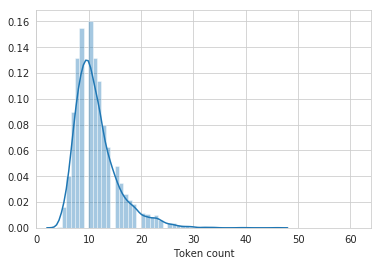

In [6]:
token_lens = [len(tokenizer.encode(txt, max_length=512)) for txt in df_train.sentence]
sns.distplot(token_lens)
plt.xlim([0, 64]);
plt.xlabel('Token count');

In [37]:
MAX_LEN = 50

In [38]:
class COLADataset(Dataset):
    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, ix):
        sentence = self.sentences[ix].lower()
        target = self.targets[ix]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [39]:
def split_data(df, split=0.2):
    df_train, df_test = train_test_split(
      df,
      test_size=split,
      random_state=RANDOM_SEED
    )
    df_val, df_test = train_test_split(
      df_test,
      test_size=0.5,
      random_state=RANDOM_SEED
    )
    print(f'Train shape: {df_train.shape}')
    print(f'Val shape: {df_val.shape}')
    print(f'Test shape: {df_test.shape}')
    return df_train, df_val, df_test

In [104]:
def get_weighted_random_sampler(df):
    counts = np.bincount(df.label)
    labels_weights = 1. / counts
    weights = labels_weights[df.label]
    return WeightedRandomSampler(weights, len(weights))

def create_data_loader(df, tokenizer, max_len, batch_size, use_weighted=False):
    dataset = COLADataset(
        sentences=df.sentence.values,
        targets=df.label.values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    if use_weighted:
        sampler = get_weighted_random_sampler(df)
    else:
        sampler = RandomSampler(dataset)
        
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=4)

In [105]:
BATCH_SIZE = 16
#df_train, df_val, df_test = split_data(df)
train_dataloader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
train_dataloader_weighted = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, use_weighted=True)
val_dataloader = create_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Check class balance for train dataloaders

In [106]:
def check_class_balance(name, dataloader):
    d = defaultdict(int)
    for batch in dataloader:
        for target in batch['targets']:
            d[target.numpy().item()] += 1
    print(name)
    for label in sorted(d.keys()):
        print(f'label: {label}, count: {d[label]}')
    print()

In [107]:
check_class_balance('imbalanced', train_dataloader)
check_class_balance('resampled', train_dataloader_weighted)

imbalanced
label: 0, count: 2528
label: 1, count: 6023

resampled
label: 0, count: 4267
label: 1, count: 4284



Check dataloader batch item shapes

In [14]:
data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


Methods for model training

Focal Loss For Dense Object Detection

Lin et al, 2018

https://arxiv.org/abs/1708.02002

![focal loss](images/focal_loss.png)

In [108]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    """
    The focal loss has a modulating factor (1 - pt)**gamma that is multiplied
    with the cross entropy loss to downweight well-classified examples and upweight hard examples.
    This loss incorporates weighted cross entropy to weight majority and minority classes but
    additionality includes this modulating factor so that well-classified examples contribute
    less to the loss while hard examples contribute more to the loss. As a result, more focus is
    given to hard examples during the optimization.
    """
    def __init__(self, weight=None, gamma=2, reduction='none'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        return focal_loss.mean()

In [109]:
def train_epoch(model, optimizer, loss_fn, train_dataloader, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    for step, batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step}/{len(train_dataloader)}')

        # add batch to gpu
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)

        model.zero_grad()

        # forward pass
        outputs = model(input_ids, token_type_ids=None,
                        attention_mask=attention_mask, labels=labels)
        
        loss = loss_fn(outputs['logits'], labels)
        #loss = outputs[0]

        _, preds = torch.max(outputs['logits'].detach(), dim=1)
        correct_predictions += torch.sum((preds == labels.detach()).cpu().float())

        losses.append(loss.item())

        # backward pass
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        
        # update parameters
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / len(train_dataloader.dataset), np.mean(losses)


def val_epoch(model, loss_fn, val_dataloader):
    model.eval()
    losses = []
    correct_predictions = 0

    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)

        with torch.no_grad():

            outputs = model(input_ids, token_type_ids=None,
                            attention_mask=attention_mask, labels=labels)
    
            loss = loss_fn(outputs['logits'], labels)
            #loss = outputs[0]
            _, preds = torch.max(outputs['logits'].detach().cpu(), dim=1)
            correct_predictions += torch.sum((preds == labels.detach().cpu()).float())
            losses.append(loss.item())
    
    return correct_predictions / len(val_dataloader.dataset), np.mean(losses)

In [110]:
MAX_GRAD_NORM = 1.0 # gradient clipping to address exploding gradients
EPOCHS = 5 # based on HuggingFace recommendations for fine-tuning
LR = 2e-5 # based on HuggingFace recommendations for fine-tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [111]:
def init_training(model, train_dataloader, weight=None, use_focal_loss=False, gamma=2.):
    """
    Initializing training modules
    Args:
      model (AlbertForSequenceClassification): initialize data parallel training if multi-GPU available
      train_dataloader (DataLoader): used to initialize total steps for schedular
      weight (Tensor): 1D tensor of weights for classes for loss function
      use_focal_loss (bool): flag to use focal loss with weights for classes
    Returns:
      model (AlbertForSequenceClassification)
      optimizer: AdamW optimizer provided by HuggingFace
      loss_fn: non-weighted CrossEntropy loss, weight CrossEntropy loss, or focal loss
      scheduler: linear schedule with warmup
    """
    
    optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    
    if weight is not None:
        weight.to(device)
        if use_focal_loss:
            loss_fn = FocalLoss(weight=weight, gamma=gamma)
        else:
            loss_fn = nn.CrossEntropyLoss(weight=weight)
    else:
        loss_fn = nn.CrossEntropyLoss()
    
    loss_fn.to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
        
    model.to(device)

    return model, optimizer, loss_fn, scheduler

In [112]:
def train(model, train_dataloader, val_dataloader, checkpoint,
          weight=None, use_focal_loss=False, gamma=2.):
    """
    Train loop
    Args:
      model (AlbertForSequenceClassification)
      train_dataloader (DataLoader)
      val_dataloader (DataLoader)
      checkpoint (str): model checkpoint path
      weight (Tensor): 1D tensor assigning weights to classes
      use_focal_loss (bool): flag to use focal loss function
    Returns:
      model (AlbertForSequenceClassification): trained model
      history (dict): loss and accuracies per epoch for train and validation
    """
    
    def format_time(elapsed):
        """
        Takes a time in seconds and returns a string hh:mm:ss
        """
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    if not os.path.exists('outputs'): os.mkdir('outputs')
    model, optimizer, loss_fn, scheduler = init_training(model, train_dataloader,
                                                         weight, use_focal_loss, gamma)

    print(f"--- Resume/Start training ---")
    history = defaultdict(list)
    best_accuracy = 0
    start_time = time.time()
    for i in range(1, EPOCHS + 1):
        print(f'--- Epoch {i} ---')
        train_acc, train_loss = train_epoch(model, optimizer, loss_fn, train_dataloader, scheduler)
        print(f'Train loss {train_loss:.3f} accuracy {train_acc:.3f}')

        val_acc, val_loss = val_epoch(model, loss_fn, val_dataloader)
        print(f'Val   loss {val_loss:.3f} accuracy {val_acc:.3f}')
        print(f'Elapsed time {format_time(time.time() - start_time)}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            print(f"--- Save to checkpoint ---")  
            torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history}
                , checkpoint)
            best_accuracy = val_acc
    return model, history

Methods for model evaluation

In [113]:
def plot_training_history(title, history):
    """
    Plot train/validation accuracies and losses over epochs
    Args:
      title (str): title of plots
      history (dict): loss and accuracies per epoch for train and validation
    """
    
    plt.figure()
    plt.plot(history['train_acc'], label='train accuracy', color='tab:blue')
    plt.plot(history['val_acc'], label='validation accuracy', color='tab:blue', linestyle='--')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    
    plt.figure()
    plt.plot(history['train_loss'], label='train loss', color='tab:blue')
    plt.plot(history['val_loss'], label='validation loss', color='tab:blue', linestyle='--')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1.5]);

In [114]:
def eval_model(model, data_loader):
    """
    Evaluates model on test accuracy (not so important when there is class imbalance)
    Args:
      model (AlbertForSequenceClassification)
      data_loader (DataLoader): test data
    """
    #loss_fn = nn.CrossEntropyLoss().to(device)
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs['logits'], dim=1)
            #loss = loss_fn(outputs['logits'], labels)
            correct_predictions += torch.sum(preds == labels)
            #losses.append(loss.item())
    print(f'Accuracy on test data: {correct_predictions.double() / len(data_loader.dataset):.3f}')
    #return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [115]:
def get_predictions(model, data_loader):
    """
    Gets predictions and probabilities for evaluating metrics
    Args:
      model (AlbertForSequenceClassification)
      data_loader (DataLoader)
    Returns:
      texts (list): raw text
      predictions (list): thresholded predictions
      prediction_probs (list): softmax normalized prediction probabilities for positive class
      real_values (list): labels
    """
    
    model = model.eval()
    texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for batch in data_loader:
            texts = batch['text']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs['logits'], dim=1)
            texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs['logits'], dim=1)[:,1])
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return texts, predictions, prediction_probs, real_values

Evaluation of baseline model

In [116]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name,
                                                        num_labels=2, 
                                                        output_attentions=False,
                                                        output_hidden_states=False)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Albert-base-v2 pretrained model parameters

Embedding layer has 128 dimensions

Hidden layers have 768 dimensions

Consists of 12 attention heads

Output dimension is 2 for our 2 classes

In [118]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The Albert model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The Albert model has 27 different named parameters.

==== Embedding Layer ====

albert.embeddings.word_embeddings.weight                (30000, 128)
albert.embeddings.position_embeddings.weight              (512, 128)
albert.embeddings.token_type_embeddings.weight              (2, 128)
albert.embeddings.LayerNorm.weight                            (128,)
albert.embeddings.LayerNorm.bias                              (128,)

==== First Transformer ====

albert.encoder.embedding_hidden_mapping_in.weight         (768, 128)
albert.encoder.embedding_hidden_mapping_in.bias               (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight   (768, 768)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias       (768,)
albert.encoder.albert_layer_groups.0.albert

In [119]:
model, history_baseline = train(model, train_dataloader, val_dataloader,
                                checkpoint='outputs/finetune_albert-base-v2_cola_baseline.pth')

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.530 accuracy 0.742
Val   loss 0.477 accuracy 0.767
Elapsed time 0:00:38
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.376 accuracy 0.845
Val   loss 0.462 accuracy 0.816
Elapsed time 0:01:17
--- Save to checkpoint ---
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.255 accuracy 0.914
Val   loss 0.491 accuracy 0.829
Elapsed time 0:01:56
--- Save to checkpoint ---
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/53

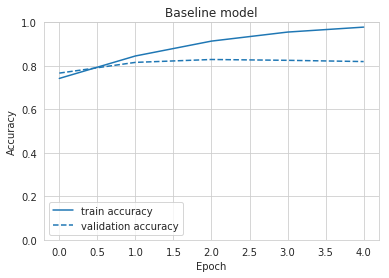

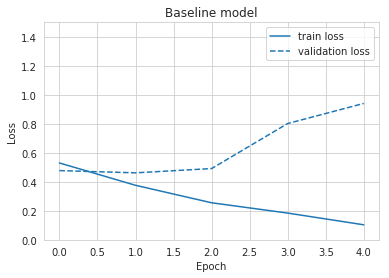

In [120]:
sns.set_style('whitegrid')
plot_training_history('Baseline model', history_baseline)

In [121]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.820


In [122]:
y_texts_baseline, y_pred_baseline, y_pred_prob_baseline, y_test_baseline = get_predictions(model, val_dataloader)

Evaluation of model with resampling

In [123]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model, history_resampled = train(model, train_dataloader_weighted, val_dataloader,
                            checkpoint='outputs/finetune_albert-base-v2_cola_resampled.pth')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.541 accuracy 0.735
Val   loss 0.570 accuracy 0.750
Elapsed time 0:00:38
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.353 accuracy 0.863
Val   loss 0.569 accuracy 0.803
Elapsed time 0:01:17
--- Save to checkpoint ---
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.246 accuracy 0.921
Val   loss 0.564 accuracy 0.846
Elapsed time 0:01:56
--- Save to checkpoint ---
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/53

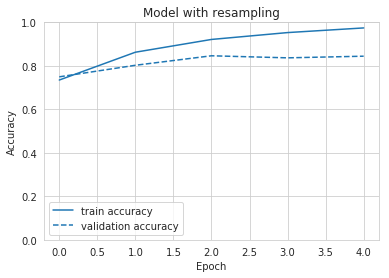

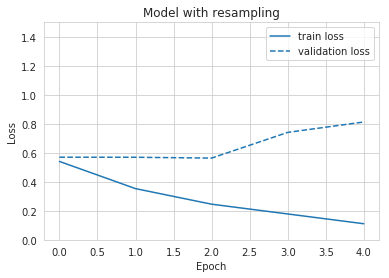

In [124]:
sns.set_style('whitegrid')
plot_training_history('Model with resampling', history_resampled)

In [125]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.844


In [126]:
y_texts_resampled, y_pred_resampled, y_pred_prob_resampled, y_test_resampled = get_predictions(model, val_dataloader)

Evaluation of model with weighted cross entropy loss

In [128]:
# Scaling by len(df_train.label/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight = (1. / np.bincount(df_train.label)) * len(df_train.label) / 2.0
weight = torch.Tensor(weight)
weight

tensor([1.6913, 0.7099])

In [129]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model, history_weightedce = train(model, train_dataloader, val_dataloader,
                                checkpoint='outputs/finetune_albert-base-v2_cola_weightedce.pth',
                                weight=weight, use_focal_loss=False)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.696 accuracy 0.526
Val   loss 0.659 accuracy 0.617
Elapsed time 0:00:38
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.571 accuracy 0.744
Val   loss 0.510 accuracy 0.772
Elapsed time 0:01:17
--- Save to checkpoint ---
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.372 accuracy 0.867
Val   loss 0.586 accuracy 0.784
Elapsed time 0:01:56
--- Save to checkpoint ---
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/53

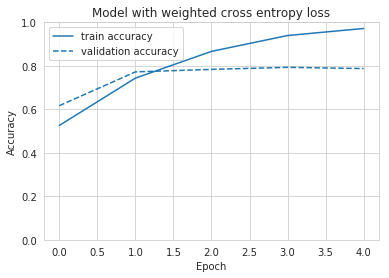

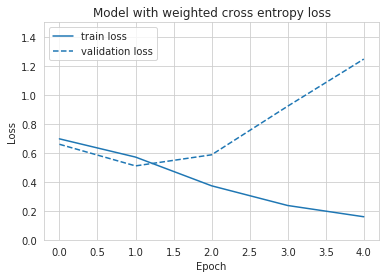

In [130]:
sns.set_style('whitegrid')
plot_training_history('Model with weighted cross entropy loss', history_weightedce)

In [131]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.787


In [132]:
y_texts_weightedce, y_pred_weightedce, y_pred_prob_weightedce, y_test_weightedce = get_predictions(model, val_dataloader)

Evaluation of model with focal loss (gamma = {0, 2, 5}) 

In [133]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model, history_focal_gamma0 = train(model, train_dataloader, val_dataloader,
                                checkpoint='outputs/finetune_albert-base-v2_cola_focal-gamma0.pth',
                                weight=weight, use_focal_loss=True, gamma=0)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.680 accuracy 0.569
Val   loss 0.648 accuracy 0.691
Elapsed time 0:00:39
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.545 accuracy 0.756
Val   loss 0.523 accuracy 0.734
Elapsed time 0:01:17
--- Save to checkpoint ---
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.363 accuracy 0.863
Val   loss 0.517 accuracy 0.808
Elapsed time 0:01:56
--- Save to checkpoint ---
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/53

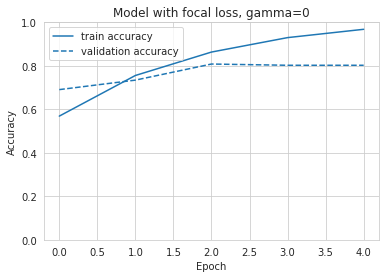

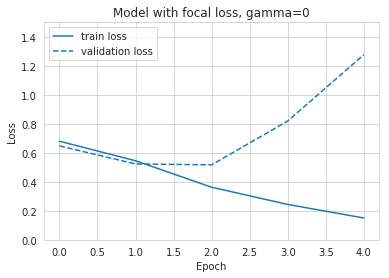

In [134]:
sns.set_style('whitegrid')
plot_training_history('Model with focal loss, gamma=0', history_focal_gamma0)

In [135]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.803


In [136]:
y_texts_focal_gamma0, y_pred_focal_gamma0, y_pred_prob_focal_gamma0, y_test_focal_gamma0 = get_predictions(model, val_dataloader)

In [137]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model, history_focal_gamma2 = train(model, train_dataloader, val_dataloader,
                                checkpoint='outputs/finetune_albert-base-v2_cola_focal-gamma2.pth',
                                weight=weight, use_focal_loss=True, gamma=2)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.177 accuracy 0.504
Val   loss 0.140 accuracy 0.558
Elapsed time 0:00:38
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.125 accuracy 0.776
Val   loss 0.197 accuracy 0.812
Elapsed time 0:01:17
--- Save to checkpoint ---
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.079 accuracy 0.899
Val   loss 0.188 accuracy 0.810
Elapsed time 0:01:56
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 4

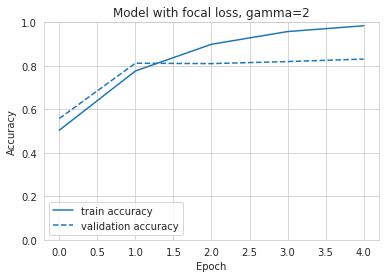

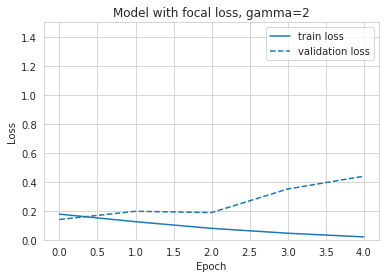

In [139]:
sns.set_style('whitegrid')
plot_training_history('Model with focal loss, gamma=2', history_focal_gamma2)

In [140]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.831


In [141]:
y_texts_focal_gamma2, y_pred_focal_gamma2, y_pred_prob_focal_gamma2, y_test_focal_gamma2 = get_predictions(model, val_dataloader)

In [142]:
model = AlbertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model, history_focal_gamma5 = train(model, train_dataloader, val_dataloader,
                                checkpoint='outputs/finetune_albert-base-v2_cola_focal-gamma5.pth',
                                weight=weight, use_focal_loss=True, gamma=5)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

--- Resume/Start training ---
--- Epoch 1 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.028 accuracy 0.329
Val   loss 0.029 accuracy 0.643
Elapsed time 0:00:38
--- Save to checkpoint ---
--- Epoch 2 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.020 accuracy 0.537
Val   loss 0.019 accuracy 0.626
Elapsed time 0:01:17
--- Epoch 3 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 400/535
  Batch 450/535
  Batch 500/535
Train loss 0.012 accuracy 0.842
Val   loss 0.029 accuracy 0.795
Elapsed time 0:01:56
--- Save to checkpoint ---
--- Epoch 4 ---
  Batch 50/535
  Batch 100/535
  Batch 150/535
  Batch 200/535
  Batch 250/535
  Batch 300/535
  Batch 350/535
  Batch 4

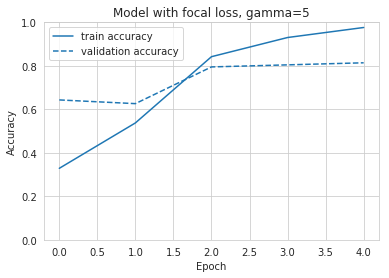

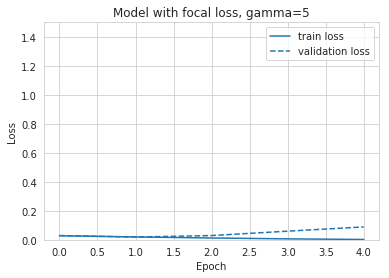

In [143]:
sns.set_style('whitegrid')
plot_training_history('Model with focal loss, gamma=5', history_focal_gamma5)

In [144]:
eval_model(model, val_dataloader)

Accuracy on test data: 0.814


In [145]:
y_texts_focal_gamma5, y_pred_focal_gamma5, y_pred_prob_focal_gamma5, y_test_focal_gamma5 = get_predictions(model, val_dataloader)

Precision, recall, and F1 metrics for baseline model

In [146]:
class_names = ['incorrect grammar', 'correct grammar']

In [147]:
print(classification_report(y_test_baseline, y_pred_baseline, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.73      0.65      0.69       162
  correct grammar       0.85      0.90      0.87       365

         accuracy                           0.82       527
        macro avg       0.79      0.77      0.78       527
     weighted avg       0.82      0.82      0.82       527



Precision, recall, and F1 metrics for model with resampling

In [148]:
print(classification_report(y_test_resampled, y_pred_resampled, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.79      0.67      0.72       162
  correct grammar       0.86      0.92      0.89       365

         accuracy                           0.84       527
        macro avg       0.83      0.79      0.81       527
     weighted avg       0.84      0.84      0.84       527



Precision, recall, and F1 metrics for model with weighted cross entropy loss

In [149]:
print(classification_report(y_test_weightedce, y_pred_weightedce, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.66      0.62      0.64       162
  correct grammar       0.84      0.86      0.85       365

         accuracy                           0.79       527
        macro avg       0.75      0.74      0.75       527
     weighted avg       0.78      0.79      0.79       527



Precision, recall, and F1 metrics for model with focal loss

In [150]:
print(classification_report(y_test_focal_gamma0, y_pred_focal_gamma0, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.70      0.64      0.66       162
  correct grammar       0.84      0.88      0.86       365

         accuracy                           0.80       527
        macro avg       0.77      0.76      0.76       527
     weighted avg       0.80      0.80      0.80       527



In [151]:
print(classification_report(y_test_focal_gamma2, y_pred_focal_gamma2, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.76      0.66      0.71       162
  correct grammar       0.86      0.91      0.88       365

         accuracy                           0.83       527
        macro avg       0.81      0.78      0.79       527
     weighted avg       0.83      0.83      0.83       527



In [152]:
print(classification_report(y_test_focal_gamma5, y_pred_focal_gamma5, target_names=class_names))

                   precision    recall  f1-score   support

incorrect grammar       0.68      0.76      0.72       162
  correct grammar       0.89      0.84      0.86       365

         accuracy                           0.81       527
        macro avg       0.78      0.80      0.79       527
     weighted avg       0.82      0.81      0.82       527



Model with resampling shows improvement over the baseline for precision, recall, and F1 score for both minority and majority classes.

Model with focal loss (gamma=5) increases the recall (+11) and F1 (+3) score of the minority class (incorrect grammar cases) compared with baseline.

Confusion matrix

In [153]:
def plot_confusion_matrix(title, y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    hmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

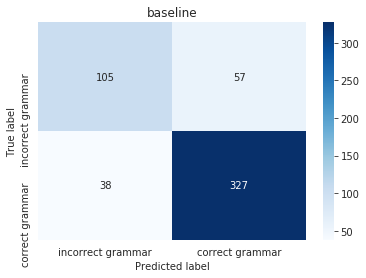

In [154]:
plot_confusion_matrix('baseline', y_test_baseline, y_pred_baseline, class_names)

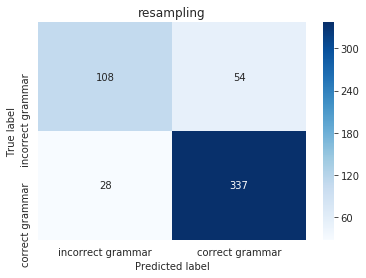

In [155]:
plot_confusion_matrix('resampling', y_test_resampled, y_pred_resampled, class_names)

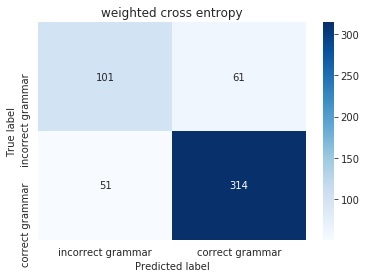

In [156]:
plot_confusion_matrix('weighted cross entropy', y_test_weightedce, y_pred_weightedce, class_names)

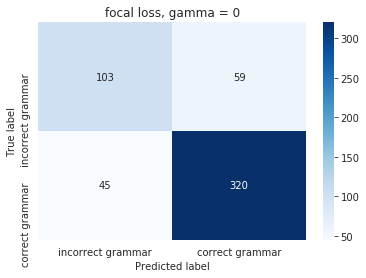

In [157]:
plot_confusion_matrix('focal loss, gamma = 0', y_test_focal_gamma0, y_pred_focal_gamma0, class_names)

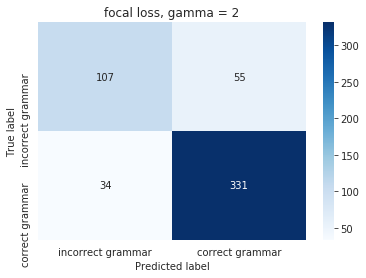

In [158]:
plot_confusion_matrix('focal loss, gamma = 2', y_test_focal_gamma2, y_pred_focal_gamma2, class_names)

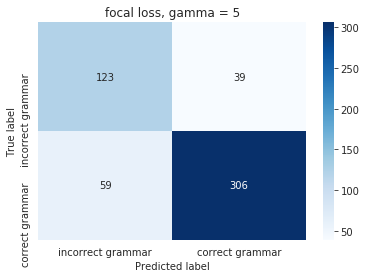

In [159]:
plot_confusion_matrix('focal loss, gamma = 5', y_test_focal_gamma5, y_pred_focal_gamma5, class_names)

When dealing with class imbalance of the CoLA dataset, my main focus was minimizing misclassification of incorrect grammar sentences. With the model trained using the focal loss and gamma = 5, the number of incorrect grammar cases classified correctly increased by 18 compared with baseline (105 to 123), and the number of incorrect grammar cases that are misclassified reduced by 18 compared with baseline (57 to 39). As expected, this also led to an increase in false negatives (correct grammar cases classified as incorrect grammar).

AUC metric

In [160]:
def plot_roc(name, labels, predictions, **kwargs):
    fpr, tpr, _ = roc_curve(labels, predictions)
    name += f' (AUC = {roc_auc_score(labels, predictions):.3f})'
    plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
    plt.title('ROC')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.set_aspect('equal')

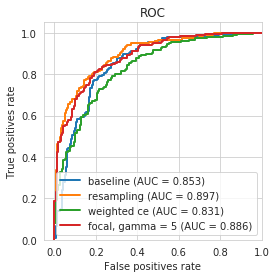

In [161]:
plot_roc('baseline', y_test_baseline, y_pred_prob_baseline)
plot_roc('resampling', y_test_resampled, y_pred_prob_resampled)
plot_roc('weighted ce', y_test_weightedce, y_pred_prob_weightedce)
plot_roc('focal, gamma = 5', y_test_focal_gamma5, y_pred_prob_focal_gamma5)

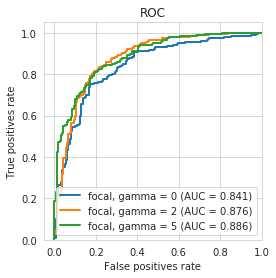

In [162]:
plot_roc('focal, gamma = 0', y_test_focal_gamma0, y_pred_prob_focal_gamma0)
plot_roc('focal, gamma = 2', y_test_focal_gamma2, y_pred_prob_focal_gamma2)
plot_roc('focal, gamma = 5', y_test_focal_gamma5, y_pred_prob_focal_gamma5)

Precision recall curve

In [163]:
def plot_pr(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    name += f' (AP = {average_precision_score(labels, predictions):.3f})'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('Precision recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.set_aspect('equal')

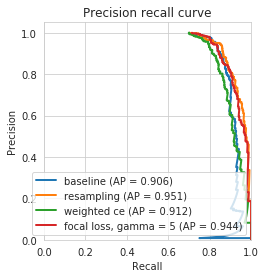

In [164]:
plot_pr('baseline', y_test_baseline, y_pred_prob_baseline)
plot_pr('resampling', y_test_resampled, y_pred_prob_resampled)
plot_pr('weighted ce', y_test_weightedce, y_pred_prob_weightedce)
plot_pr('focal loss, gamma = 5', y_test_focal_gamma5, y_pred_prob_focal_gamma5)

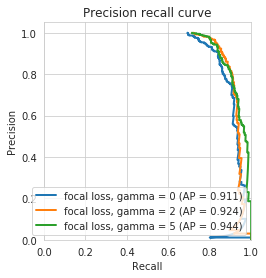

In [165]:
plot_pr('focal loss, gamma = 0', y_test_focal_gamma0, y_pred_prob_focal_gamma0)
plot_pr('focal loss, gamma = 2', y_test_focal_gamma2, y_pred_prob_focal_gamma2)
plot_pr('focal loss, gamma = 5', y_test_focal_gamma5, y_pred_prob_focal_gamma5)

Model explainability using SHAP

In [169]:
import pprint
data = next(iter(train_dataloader))
pprint.pprint(list(zip(data['text'], data['targets'])))

[('mr knightley walked into the drawing room.', tensor(1)),
 ('a dog lay in the comer.', tensor(1)),
 ('dana longs for a sunny day.', tensor(1)),
 ('john seems will win.', tensor(0)),
 ('jason intended for him to learn magic.', tensor(1)),
 ('what jason asked whether was the potion was ready', tensor(0)),
 ("i don't plan to lock the door, no matter how fancy this hotel.", tensor(0)),
 ('the world saw the beginning of a new era in 1492.', tensor(1)),
 ('a solution immediately presented.', tensor(0)),
 ('jake threw the ball all the way to bill.', tensor(1)),
 ('the kennel in which mary keeps drugs and fido sleeps has been stolen.',
  tensor(1)),
 ('john remained somewhat calm.', tensor(1)),
 ('john can go to the market to india.', tensor(0)),
 ("flo desperately wants, though she doesn't really expect, the miami dolphins "
  'to be in the play-offs.',
  tensor(1)),
 ('the clown amused the children with his antics.', tensor(1)),
 ('the roof of the building is leaking.', tensor(1))]


In [170]:
model.cpu()
classifier = transformers.TextClassificationPipeline(model=model,
                                                     tokenizer=tokenizer,
                                                     return_all_scores=True)
explainer = shap.Explainer(classifier)
shap_values = explainer(data['text'])
shap.plots.text(shap_values)

,,mr,knight,ley walked,into the,drawing room,.,
LABEL_0,0.0,-0.192,-0.107,-0.286,-0.291,-0.268,-0.023,0.0
LABEL_1,-0.0,0.192,0.107,0.286,0.291,0.268,0.023,-0.0


,,a,dog,lay,in,the come r,.,
LABEL_0,0.0,0.048,-0.286,-0.114,-0.123,-0.447,-0.029,0.0
LABEL_1,-0.0,-0.048,0.286,0.114,0.123,0.447,0.029,-0.0


,,dana,long,s,for,a sunny day,.,
LABEL_0,-0.0,0.062,-0.41,-0.186,-0.101,-0.589,-0.047,0.0
LABEL_1,-0.0,-0.062,0.41,0.186,0.101,0.589,0.047,-0.0


,,john,seems,will,win,.,
LABEL_0,-0.0,0.204,1.119,1.071,0.253,0.046,-0.0
LABEL_1,0.0,-0.204,-1.119,-1.071,-0.253,-0.046,0.0


,,jason,intended,for him,to learn,magic,.,
LABEL_0,0.0,0.046,-0.359,-0.311,-0.421,-0.151,-0.051,-0.0
LABEL_1,0.0,-0.046,0.359,0.311,0.421,0.151,0.051,0.0


,,what jason,asked,whether,was,the,potion was ready,
LABEL_0,-0.0,0.653,0.31,0.346,0.335,0.319,0.654,0.0
LABEL_1,-0.0,-0.653,-0.31,-0.346,-0.335,-0.319,-0.654,-0.0


,,i don ' t,"plan to lock the door ,",no matter,how fancy,this hotel,.,
LABEL_0,-0.0,0.49,0.488,0.127,0.362,0.455,0.033,0.0
LABEL_1,0.0,-0.49,-0.488,-0.127,-0.362,-0.455,-0.033,-0.0


,,the world,saw the,beginning of a new,era in,14 92,.,
LABEL_0,-0.0,-0.053,-0.255,-0.306,-0.257,-0.321,-0.034,-0.0
LABEL_1,0.0,0.053,0.255,0.306,0.257,0.321,0.034,0.0


,,a,solution,immediately,presented,.,
LABEL_0,0.0,0.559,0.4,0.674,0.285,0.14,-0.0
LABEL_1,0.0,-0.559,-0.4,-0.674,-0.285,-0.14,0.0


,,jake,threw,the,ball,all the way to bill,.,
LABEL_0,-0.0,0.047,-0.249,-0.12,-0.204,-0.525,-0.004,0.0
LABEL_1,-0.0,-0.047,0.249,0.12,0.204,0.525,0.004,-0.0


,,the kennel in which,mary keeps drugs and,f ido sleep s,has,been,stolen,.,
LABEL_0,0.0,-0.023,-0.023,-0.023,-0.034,-0.031,-0.056,0.097,-0.0
LABEL_1,-0.0,0.023,0.023,0.023,0.034,0.031,0.056,-0.097,0.0


,,john,remained,somewhat,calm,.,
LABEL_0,0.0,-0.272,-0.307,-0.299,-0.278,-0.32,0.0
LABEL_1,0.0,0.272,0.307,0.299,0.278,0.32,-0.0


,,john can,go to,the market,to india,.,
LABEL_0,0.0,0.666,0.655,0.659,0.671,-0.007,0.0
LABEL_1,-0.0,-0.666,-0.655,-0.659,-0.671,0.007,-0.0


,,flo desperately wants,",",though she doesn ' t,"really expect ,",the miami dolphins to,be in the play,- offs .,
LABEL_0,-0.0,-0.226,0.017,-0.087,-0.126,-0.21,-0.152,-0.062,-0.0
LABEL_1,0.0,0.226,-0.017,0.087,0.126,0.21,0.152,0.062,-0.0


,,the,clown,amused,the,children with his an tics,.,
LABEL_0,-0.0,-0.15,-0.161,-0.222,-0.117,-0.596,-0.054,0.0
LABEL_1,0.0,0.15,0.161,0.222,0.117,0.596,0.054,0.0


,,the roof,of,the,building is,leaking,.,
LABEL_0,-0.0,-0.211,-0.124,-0.116,-0.313,-0.1,-0.036,-0.0
LABEL_1,0.0,0.211,0.124,0.116,0.313,0.1,0.036,0.0
